In [30]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

# Helper Functions

In [2]:
def reformat_allele(allele: str, resolution: int = 2) -> str:
    """
    Reformats an allele string to a standard format.
    For example, for two-field resolution:
      "A*01:03:XX" -> "A*01:03"
    For one-field resolution:
      "A*01:03" -> "A*01"
    """
    allele = allele.strip()
    if "*" not in allele:
        return allele
    gene, rest = allele.split("*", 1)
    fields = rest.split(":")
    if resolution == 1:
        return f"{gene}*{fields[0]}"
    elif resolution == 2:
        if len(fields) >= 2:
            return f"{gene}*{fields[0]}:{fields[1]}"
        else:
            return f"{gene}*{fields[0]}"
    else:
        return allele

def compare_allele_pair(gs_alleles: list, pre_alleles: list, resolution: int = 2) -> int:
    """
    Compares a pair of gold-standard alleles (list of two strings) 
    with a pair of predicted alleles.
    Returns the maximum number of matches (0, 1, or 2) by checking both 
    the parallel and cross comparisons.
    """
    gs_fmt = [reformat_allele(a, resolution) for a in gs_alleles]
    pre_fmt = [reformat_allele(a, resolution) for a in pre_alleles]
    
    parallel = (gs_fmt[0] == pre_fmt[0]) + (gs_fmt[1] == pre_fmt[1])
    cross = (gs_fmt[0] == pre_fmt[1]) + (gs_fmt[1] == pre_fmt[0])
    return max(parallel, cross)

def compare_allele_pair_filtered(gs_alleles: list, pre_alleles: list, valid_flags: list, resolution: int = 2) -> int:
    """
    Like compare_allele_pair, but only counts a predicted allele if it is valid.
    valid_flags is a list of booleans (one per allele) indicating whether the corresponding
    predicted allele passes the valid-set filter.
    For invalid predictions, that allele is treated as a "no call" (i.e. contributes 0 to the match).
    """
    gs_fmt = [reformat_allele(a, resolution) for a in gs_alleles]
    # For each predicted allele, only reformat it if it is valid; otherwise, set to None.
    pre_fmt = [reformat_allele(a, resolution) if valid else None for a, valid in zip(pre_alleles, valid_flags)]
    
    # For parallel comparison, count a match only if the predicted allele is valid.
    parallel = 0
    if pre_fmt[0] is not None and gs_fmt[0] == pre_fmt[0]:
        parallel += 1
    if pre_fmt[1] is not None and gs_fmt[1] == pre_fmt[1]:
        parallel += 1
    
    # Cross comparison.
    cross = 0
    if pre_fmt[1] is not None and gs_fmt[0] == pre_fmt[1]:
        cross += 1
    if pre_fmt[0] is not None and gs_fmt[1] == pre_fmt[0]:
        cross += 1
    return max(parallel, cross)





In [3]:
def get_dynamic_loci_from_gs(gs_df: pd.DataFrame) -> list:
    """
    Assumes the first column is a sample identifier.
    Every column after that corresponds to a locus.
    If a column name contains a '.1' suffix, it is removed.
    Returns a unique list of locus names.
    """
    loci = set()
    for col in gs_df.columns[1:]:
        # Remove any '.1' suffix
        locus = col.split('.')[0]
        loci.add(locus)
    return list(loci)

In [ ]:
def calculate_accuracy(gs_file: str, pre_file: str, resolution: int = 2, filter_option: bool = False):
    """
    Reads the gold standard and prediction CSV files and computes overall accuracy.
    
    Assumptions:
      - The gold-standard CSV (gs_file) has a "Run" column and columns for each locus.
        For each locus, there may be one column (e.g. "DRB1_gs") or two (e.g. "DRB1_gs" and "DRB1.1_gs").
      - The prediction CSV (pre_file) has an "ERR" column that matches the gold standard "Run" identifiers.
        For each locus, predictions are expected in a column named "{locus}_pre"; if a second prediction exists,
        it should be in a column named "{locus}.1_pre". If only one prediction is available for a diploid locus,
        it will be duplicated.
      
    filter_option: if True, only predicted alleles that appear in the gold-standard valid set (built from gs_file)
                   are counted in the accuracy calculation.
    
    Returns:
      A tuple (accuracy, total_correct, total_valid_calls, miscalled_alleles)
    """
    gs_df = pd.read_csv(gs_file)
    pre_df = pd.read_csv(pre_file)
    
    
    # Dynamically determine loci from the gold standard.
    loci = get_dynamic_loci_from_gs(gs_df)
    #print(loci)
    
    id_col_gs = gs_df.columns[0]
    id_col_pre = pre_df.columns[0]
    merged_df = pd.merge(gs_df, pre_df, left_on=id_col_gs, right_on=id_col_pre, suffixes=("_gs", "_pre"))
    #print(merged_df)
    total_correct = 0
    total_calls = 0
    miscalled_alleles = []
    
    # Build valid allele sets for filtering if enabled.
    valid_set = {}
    if filter_option:
        valid_set = {locus: set() for locus in loci}
        for _, row in gs_df.iterrows():
            for col in gs_df.columns[1:]:
                locus = col.split('.')[0]
                if locus in loci:
                    gs_val = row[col]
                    if pd.isna(gs_val):
                        continue
                    for allele in str(gs_val).split("/"):
                        valid_set[locus].add(reformat_allele(allele.strip(), resolution))
    
    for _, row in merged_df.iterrows():
        #print(row)
        for locus in loci:
            # Retrieve gold-standard alleles from all GS columns for this locus.
            gs_alleles_raw = []
            col1 = f"{locus}_gs"
            col2 = f"{locus}.1_gs"
            if col1 in row and not pd.isna(row[col1]):
                gs_alleles_raw.extend([a.strip() for a in str(row[col1]).split("/")])
            if col2 in row and not pd.isna(row[col2]):
                gs_alleles_raw.extend([a.strip() for a in str(row[col2]).split("/")])
            if not gs_alleles_raw:
                continue
            #print(gs_alleles_raw)
            # Form the union of all reformatted alleles.
            gs_allele_set = set(reformat_allele(a, resolution) for a in gs_alleles_raw)
            #print(gs_allele_set)
            # Decide mode: if more than two distinct alleles exist, use ambiguous mode.
            use_ambiguous = len(gs_allele_set) > 2
            
            # If not ambiguous, if the set has only one allele, duplicate it; if two, convert to list.
            if not use_ambiguous:
                gs_alleles = list(gs_allele_set)
                if len(gs_alleles) == 1:
                    gs_alleles = [gs_alleles[0], gs_alleles[0]]
            # Otherwise, in ambiguous mode, we simply use the full set.
            
            # Retrieve predicted alleles.
            pre_alleles = []
            pre_col1 = f"{locus}_pre"
            pre_col2 = f"{locus}.1_pre"
            if pre_col1 in row and not pd.isna(row[pre_col1]):
                pre_alleles.extend([a.strip() for a in str(row[pre_col1]).split("/")])
            if pre_col2 in row and not pd.isna(row[pre_col2]):
                pre_alleles.extend([a.strip() for a in str(row[pre_col2]).split("/")])
            if not pre_alleles:
                continue
            # If only one prediction is provided, duplicate it; if more than two, take first two.
            if len(pre_alleles) == 1:
                pre_alleles = [pre_alleles[0], pre_alleles[0]]
            elif len(pre_alleles) > 2:
                pre_alleles = pre_alleles[:2]
            if len(pre_alleles) != 2:
                continue
            
            # Compare predicted alleles to gold standard.
            if use_ambiguous:
                # In ambiguous mode, count each predicted allele as correct if it appears in the full GS set.
                pred1 = reformat_allele(pre_alleles[0], resolution)
                pred2 = reformat_allele(pre_alleles[1], resolution)
                match_count = (1 if pred1 in gs_allele_set else 0) + (1 if pred2 in gs_allele_set else 0)
            else:
                match_count = compare_allele_pair(gs_alleles, pre_alleles, resolution)
            
            if filter_option:
                valid_flags = []
                for allele in pre_alleles:
                    allele_fmt = reformat_allele(allele, resolution)
                    valid_flags.append(allele_fmt in valid_set.get(locus, set()))
                valid_call_count = sum(valid_flags)
                total_calls += valid_call_count
                if not use_ambiguous:
                    match_count = compare_allele_pair_filtered(gs_alleles, pre_alleles, valid_flags, resolution)
                total_correct += match_count
                if match_count < valid_call_count:
                    miscalled_alleles.extend(list(gs_allele_set))
            else:
                total_correct += match_count
                total_calls += 2
                if match_count < 2:
                    miscalled_alleles.extend(list(gs_allele_set))
    
    accuracy = total_correct / total_calls if total_calls > 0 else 0
    return accuracy, total_correct, total_calls, miscalled_alleles

In [5]:
gs_file = "../datasets/1_gs.csv"       # Path to gold standard file.
pre_file = "../results/standard/arcas_d1.csv"  # Path to tool prediction file.

# Calculate accuracy without filtering.
calculate_accuracy(gs_file, pre_file, resolution=2, filter_option=False)


(0.9371428571428572,
 4592,
 4900,
 ['DQB1*03:24',
  'DQB1*03:09',
  'DQB1*03:22',
  'DQB1*03:21',
  'DQB1*03:19',
  'DQB1*03:01',
  'B*2',
  'B*1900 9:01',
  'B*41:02',
  'B*1',
  'A*02:01',
  'A*02:75',
  'A*32:01',
  'A*02:43',
  'A*02:14',
  'A*02:89',
  'A*02:97',
  'A*02:66',
  'A*02:13',
  'A*02:09',
  'A*02:83',
  'A*03:45',
  'A*11:01',
  'A*03:37',
  'A*03:20',
  'A*03:26',
  'A*11:21',
  'A*03:01',
  'A*03:21',
  'A*11:01',
  'A*01:01',
  'A*01:04',
  'A*01:37',
  'A*01:32',
  'A*01:22',
  'A*11:21',
  'A*01:34',
  'DQB1*02:01',
  'DQB1*02:04',
  'DQB1*02:02',
  'DQB1*02:01',
  'C*08:02',
  'C*07:01',
  'C*03:03',
  'C*03:20',
  'C*02:02',
  'B*27:05',
  'B*27:13',
  'DQB1*06:05',
  'DQB1*03:01',
  'B*27:03',
  'B*07:02',
  'B*27:52',
  'B*27:09',
  'DQB1*03:24',
  'DQB1*03:09',
  'DQB1*03:22',
  'DQB1*03:21',
  'DQB1*03:19',
  'DQB1*03:01',
  'DQB1*02:01',
  'DQB1*03:01',
  'DQB1*06:02',
  'DQB1*03:01',
  'A*25:01',
  'A*11:01',
  'A*02:01',
  'A*02:75',
  'A*11:01',
  'A*0

In [6]:

gs_file = "../datasets/1_gs.csv"       # Path to gold standard file.
pre_file = "../results/standard/arcas_d1.csv"  # Path to tool prediction file.

# Calculate accuracy without filtering.
accuracy, correct, calls, miscalled = calculate_accuracy(gs_file, pre_file, resolution=2, filter_option=False)
print("Without filtering:")
print(f"Overall two-field accuracy: {accuracy:.3f}")
print(f"Total correct calls: {correct} / {calls}")
print(f"Number of miscalled alleles: {len(miscalled)}")

#Calculate accuracy with filtering enabled.
accuracy_filt, correct_filt, calls_filt, miscalled_filt = calculate_accuracy(gs_file, pre_file, resolution=2, filter_option=True)
print("\nWith filtering:")
print(f"Overall two-field accuracy: {accuracy_filt:.3f}")
print(f"Total correct calls: {correct_filt} / {calls_filt}")
print(f"Number of miscalled alleles: {len(miscalled_filt)}")


Without filtering:
Overall two-field accuracy: 0.937
Total correct calls: 4592 / 4900
Number of miscalled alleles: 1052

With filtering:
Overall two-field accuracy: 0.970
Total correct calls: 4592 / 4732
Number of miscalled alleles: 239


# Accuracy by Dataset

In [77]:
import pandas as pd

# List of tool names that you want to evaluate.
tools = ["arcas", "optitype", "seq2HLA", "hlaminer", "phlat", "hla_vbseq", "hla_hd"]
# Dataset numbers to iterate over.
dataset_nums = range(1, 9)

# List to store results.
results = []

# Loop over each tool and each dataset.
for tool in tools:
    for ds in dataset_nums:
        gs_file = f"../datasets/{ds}_gs.csv"             # Gold standard file for dataset ds.
        pre_file = f"../results/standard/{tool}_d{ds}.csv"         # Prediction file for the tool on dataset ds.
        try:
            # Call our accuracy function (adjust resolution and filter_option as needed).
            accuracy, correct, calls, miscalled = calculate_accuracy(gs_file, pre_file, resolution=2, filter_option=False)
            results.append({
                "Tool": tool,
                "Dataset": ds,
                "Accuracy": accuracy,
                "CorrectCalls": correct,
                "TotalCalls": calls,
                "NumMiscalled": len(miscalled)
            })
            print(f"Processed {tool} on dataset {ds}: Accuracy = {accuracy:.3f}")
        except Exception as e:
            print(f"Error processing {tool} on dataset {ds}: {e}")

# Convert results to a DataFrame and save or display.
df_results = pd.DataFrame(results)
print("\nSummary of Accuracy Evaluations:")
#print(df_results)
df_results
# Optionally, write the summary to a CSV file.
#df_results.to_csv("accuracy_summary.csv", index=False)


Processed arcas on dataset 1: Accuracy = 0.937
Processed arcas on dataset 2: Accuracy = 0.948
Processed arcas on dataset 3: Accuracy = 0.677
Processed arcas on dataset 4: Accuracy = 1.000
Processed arcas on dataset 5: Accuracy = 1.000
Processed arcas on dataset 6: Accuracy = 1.000
Processed arcas on dataset 7: Accuracy = 0.312
Error processing arcas on dataset 8: [Errno 2] No such file or directory: '../results/standard/arcas_d8.csv'
Processed optitype on dataset 1: Accuracy = 0.982
Processed optitype on dataset 2: Accuracy = 0.000
Processed optitype on dataset 3: Accuracy = 0.940
Processed optitype on dataset 4: Accuracy = 0.000
Processed optitype on dataset 5: Accuracy = 0.625
Processed optitype on dataset 6: Accuracy = 1.000
Processed optitype on dataset 7: Accuracy = 0.357
Error processing optitype on dataset 8: [Errno 2] No such file or directory: '../results/standard/optitype_d8.csv'
Processed seq2HLA on dataset 1: Accuracy = 0.920
Processed seq2HLA on dataset 2: Accuracy = 0.292

,Tool,Dataset,Accuracy,CorrectCalls,TotalCalls,NumMiscalled
0,arcas,1,0.937143,4592,4900,1052
1,arcas,2,0.947674,163,172,18
2,arcas,3,0.676667,203,300,143
3,arcas,4,1.000000,4,4,0
4,arcas,5,1.000000,16,16,0
5,arcas,6,1.000000,8,8,0
6,arcas,7,0.312500,30,96,89
7,optitype,1,0.981973,2887,2940,121
8,optitype,2,0.000000,0,0,0
9,optitype,3,0.940000,282,300,28


In [76]:
import pandas as pd

# List of tool names that you want to evaluate.
tools = ["arcas", "optitype", "seq2HLA", "hlaminer", "phlat", "hla_vbseq", "hla_hd"]
# Dataset numbers to iterate over.
dataset_nums = range(1, 9)

# List to store results.
results = []

# Loop over each tool and each dataset.
for tool in tools:
    for ds in dataset_nums:
        gs_file = f"../datasets/{ds}_gs.csv"             # Gold standard file for dataset ds.
        pre_file = f"../results/standard/{tool}_d{ds}.csv"         # Prediction file for the tool on dataset ds.
        try:
            # Call our accuracy function (adjust resolution and filter_option as needed).
            accuracy, correct, calls, miscalled = calculate_accuracy(gs_file, pre_file, resolution=1, filter_option=False)
            results.append({
                "Tool": tool,
                "Dataset": ds,
                "Accuracy": accuracy,
                "CorrectCalls": correct,
                "TotalCalls": calls,
                "NumMiscalled": len(miscalled)
            })
            print(f"Processed {tool} on dataset {ds}: Accuracy = {accuracy:.3f}")
        except Exception as e:
            print(f"Error processing {tool} on dataset {ds}: {e}")

# Convert results to a DataFrame and save or display.
df_results = pd.DataFrame(results)
print("\nSummary of Accuracy Evaluations:")
#print(df_results)
df_results
# Optionally, write the summary to a CSV file.
#df_results.to_csv("accuracy_summary.csv", index=False)



Processed arcas on dataset 1: Accuracy = 0.991
Processed arcas on dataset 2: Accuracy = 0.977
Processed arcas on dataset 3: Accuracy = 0.970
Processed arcas on dataset 4: Accuracy = 1.000
Processed arcas on dataset 5: Accuracy = 1.000
Processed arcas on dataset 6: Accuracy = 1.000
Processed arcas on dataset 7: Accuracy = 0.615
Error processing arcas on dataset 8: [Errno 2] No such file or directory: '../results/standard/arcas_d8.csv'
Processed optitype on dataset 1: Accuracy = 0.997
Processed optitype on dataset 2: Accuracy = 0.000
Processed optitype on dataset 3: Accuracy = 0.973
Processed optitype on dataset 4: Accuracy = 0.000
Processed optitype on dataset 5: Accuracy = 0.625
Processed optitype on dataset 6: Accuracy = 1.000
Processed optitype on dataset 7: Accuracy = 0.417
Error processing optitype on dataset 8: [Errno 2] No such file or directory: '../results/standard/optitype_d8.csv'
Processed seq2HLA on dataset 1: Accuracy = 0.970
Processed seq2HLA on dataset 2: Accuracy = 0.673

,Tool,Dataset,Accuracy,CorrectCalls,TotalCalls,NumMiscalled
0,arcas,1,0.991020,4856,4900,80
1,arcas,2,0.976744,168,172,8
2,arcas,3,0.970000,291,300,15
3,arcas,4,1.000000,4,4,0
4,arcas,5,1.000000,16,16,0
5,arcas,6,1.000000,8,8,0
6,arcas,7,0.614583,59,96,70
7,optitype,1,0.996599,2930,2940,14
8,optitype,2,0.000000,0,0,0
9,optitype,3,0.973333,292,300,11


# Bulk Accuracy

In [ ]:
import pandas as pd

# List of tool names that you want to evaluate.
tools = ["arcas", "optitype", "seq2hla", "hlaminer", "phlat", "hla_vbseq", "hlahd", "hisat_genotype"]
# Dataset numbers to iterate over.
dataset_nums = range(1, 9)

# List to store per-dataset results.
results_2field = []
results_1field=[]
results_2field_filtered = []
results_1field_filtered=[]


# Loop over each tool and each dataset.
for tool in tools:
    for ds in dataset_nums:
        gs_file = f"../datasets/{ds}_gs.csv"             # Gold standard file for dataset ds.
        pre_file = f"../results/standard/{tool}_d{ds}.csv"         # Prediction file for the tool on dataset ds.
        try:
            # Call our accuracy function (adjust resolution and filter_option as needed).
            accuracy_2field, correct_2field, calls_2field, miscalled_2field = calculate_accuracy(gs_file, pre_file, resolution=2, filter_option=False)
            accuracy_1field, correct_1field, calls_1field, miscalled_1field = calculate_accuracy(gs_file, pre_file, resolution=1, filter_option=False)
            accuracy_2field_filtered, correct_2field_filtered, calls_2field_filtered, miscalled_2field_filtered = calculate_accuracy(gs_file, pre_file, resolution=2, filter_option=True)
            accuracy_1field_filtered, correct_1field_filtered, calls_1field_filtered, miscalled_1field_filtered = calculate_accuracy(gs_file, pre_file, resolution=1, filter_option=True)
            results_items=['2field', '1field', '2field_filtered', '1field_filtered']
            results_2field.append({
                "Tool": tool,
                "Dataset": ds,
                "Accuracy": accuracy_2field,
                "CorrectCalls": correct_2field,
                "TotalCalls": calls_2field,
                "NumMiscalled": len(miscalled_2field)
            })
            results_1field.append({
                            "Tool": tool,
                            "Dataset": ds,
                            "Accuracy": accuracy_1field,
                            "CorrectCalls": correct_1field,
                            "TotalCalls": calls_1field,
                            "NumMiscalled": len(miscalled_1field)
                        })
            results_2field_filtered.append({
                "Tool": tool,
                "Dataset": ds,
                "Accuracy": accuracy_2field_filtered,
                "CorrectCalls": correct_2field_filtered,
                "TotalCalls": calls_2field_filtered,
                "NumMiscalled": len(miscalled_2field_filtered)
            })
            results_1field_filtered.append({
                "Tool": tool,
                "Dataset": ds,
                "Accuracy": accuracy_1field_filtered,
                "CorrectCalls": correct_1field_filtered,
                "TotalCalls": calls_1field_filtered,
                "NumMiscalled": len(miscalled_1field_filtered)
            })
            print(f"Processed {tool} on dataset {ds}: Accuracy_2field = {accuracy_2field:.3f}")
            print(f"Processed {tool} on dataset {ds}: Accuracy_1field = {accuracy_1field:.3f}")
            print(f"Processed {tool} on dataset {ds}: Accuracy_2field_filtered = {accuracy_2field_filtered:.3f}")
            print(f"Processed {tool} on dataset {ds}: Accuracy_1field_filtered = {accuracy_1field_filtered:.3f}")


        except Exception as e:
            print(f"Error processing {tool} on dataset {ds}: {e}")

# Convert per-dataset results to a DataFrame.
results_2field = pd.DataFrame(results_2field)
results_1field = pd.DataFrame(results_1field)
results_2field_filtered = pd.DataFrame(results_2field_filtered)
results_1field_filtered = pd.DataFrame(results_1field_filtered)
print("\nPer-dataset Accuracy Evaluations:")


# # Now, group the results by tool to compute bulk accuracy.
results_2field = results_2field.groupby("Tool").agg({
     "CorrectCalls": "sum",
     "TotalCalls": "sum"
 }).reset_index()
results_2field["BulkAccuracy"] = results_2field["CorrectCalls"] / results_2field["TotalCalls"]
results_2field['BulkAccuracy%']=results_2field['BulkAccuracy']*100

results_1field = results_1field.groupby("Tool").agg({
     "CorrectCalls": "sum",
     "TotalCalls": "sum"
 }).reset_index()
results_1field["BulkAccuracy"] = results_1field["CorrectCalls"] / results_1field["TotalCalls"]
results_1field['BulkAccuracy%']=results_1field['BulkAccuracy']*100


results_2field_filtered = results_2field_filtered.groupby("Tool").agg({
     "CorrectCalls": "sum",
     "TotalCalls": "sum"
 }).reset_index()
results_2field_filtered["BulkAccuracy"] = results_2field_filtered["CorrectCalls"] / results_2field_filtered["TotalCalls"]
results_2field_filtered['BulkAccuracy%']=results_2field_filtered['BulkAccuracy']*100



results_1field_filtered = results_1field_filtered.groupby("Tool").agg({
     "CorrectCalls": "sum",
     "TotalCalls": "sum"
 }).reset_index()
results_1field_filtered["BulkAccuracy"] = results_2field_filtered["CorrectCalls"] / results_1field_filtered["TotalCalls"]
results_1field_filtered['BulkAccuracy%']=results_2field_filtered['BulkAccuracy']*100

# print("\nBulk Accuracy (across all datasets):")
# bulk
# bulk['BulkAccuracy%']=bulk['BulkAccuracy']*100


# Optionally, save results to CSV files.
#df_results.to_csv("accuracy_summary_per_dataset.csv", index=False)
#bulk.to_csv("bulk_accuracy_summary.csv", index=False)


Processed arcas on dataset 1: Accuracy_2field = 0.937
Processed arcas on dataset 1: Accuracy_1field = 0.991
Processed arcas on dataset 1: Accuracy_2field_filtered = 0.970
Processed arcas on dataset 1: Accuracy_1field_filtered = 0.991
Processed arcas on dataset 2: Accuracy_2field = 0.948
Processed arcas on dataset 2: Accuracy_1field = 0.977
Processed arcas on dataset 2: Accuracy_2field_filtered = 0.976
Processed arcas on dataset 2: Accuracy_1field_filtered = 0.977
Processed arcas on dataset 3: Accuracy_2field = 0.677
Processed arcas on dataset 3: Accuracy_1field = 0.970
Processed arcas on dataset 3: Accuracy_2field_filtered = 0.927
Processed arcas on dataset 3: Accuracy_1field_filtered = 0.970
Processed arcas on dataset 4: Accuracy_2field = 1.000
Processed arcas on dataset 4: Accuracy_1field = 1.000
Processed arcas on dataset 4: Accuracy_2field_filtered = 1.000
Processed arcas on dataset 4: Accuracy_1field_filtered = 1.000
Processed arcas on dataset 5: Accuracy_2field = 1.000
Processed 

In [80]:
results_2field

,Tool,CorrectCalls,TotalCalls,BulkAccuracy,BulkAccuracy%
0,arcas,5016,5496,0.912664,91.266376
1,hlaminer,437,5374,0.081317,8.131745
2,optitype,3217,3348,0.960872,96.087216
3,phlat,4464,5410,0.825139,82.513863
4,seq2HLA,4778,5420,0.881550,88.154982


In [81]:
results_1field

,Tool,CorrectCalls,TotalCalls,BulkAccuracy,BulkAccuracy%
0,arcas,5402,5496,0.982897,98.289665
1,hlaminer,1343,5374,0.249907,24.990696
2,optitype,3275,3348,0.978196,97.819594
3,phlat,4894,5410,0.904621,90.462107
4,seq2HLA,5181,5420,0.955904,95.590406


In [102]:
results_1field['type']='pre-filter'
results_1field_filtered['type']='filtered'
field_1_df=pd.concat([results_1field,results_1field_filtered])

results_2field['type']='pre-filter'
results_2field_filtered['type']='filtered'
field_2_df=pd.concat([results_1field,results_1field_filtered])


In [125]:
field_2_df

,Tool,CorrectCalls,TotalCalls,BulkAccuracy,BulkAccuracy%,type
0,arcas,5402,5496,0.982897,98.289665,pre-filter
1,hlaminer,1343,5374,0.249907,24.990696,pre-filter
2,optitype,3275,3348,0.978196,97.819594,pre-filter
3,phlat,4894,5410,0.904621,90.462107,pre-filter
4,seq2HLA,5181,5420,0.955904,95.590406,pre-filter
0,arcas,5402,5495,0.912830,96.610169,filtered
1,hlaminer,1343,5223,0.083668,18.028053,filtered
2,optitype,3275,3336,0.964329,97.307925,filtered
3,phlat,4894,5399,0.826820,88.099467,filtered
4,seq2HLA,5181,5405,0.883996,95.027844,filtered


## bulk accuracy by class

Error processing arcas on dataset 8: [Errno 2] No such file or directory: '../results/standard/arcas_d8.csv'
Error processing optitype on dataset 8: [Errno 2] No such file or directory: '../results/standard/optitype_d8.csv'
Error processing seq2hla on dataset 7: [Errno 2] No such file or directory: '../results/standard/seq2hla_d7.csv'
Error processing seq2hla on dataset 8: [Errno 2] No such file or directory: '../results/standard/seq2hla_d8.csv'
Error processing hlaminer on dataset 8: [Errno 2] No such file or directory: '../results/standard/hlaminer_d8.csv'
Error processing phlat on dataset 7: [Errno 2] No such file or directory: '../results/standard/phlat_d7.csv'
Error processing phlat on dataset 8: [Errno 2] No such file or directory: '../results/standard/phlat_d8.csv'
Error processing hlavbseq on dataset 8: [Errno 2] No such file or directory: '../results/standard/hlavbseq_d8.csv'
Error processing hlahd on dataset 7: [Errno 2] No such file or directory: '../results/standard/hlahd_d

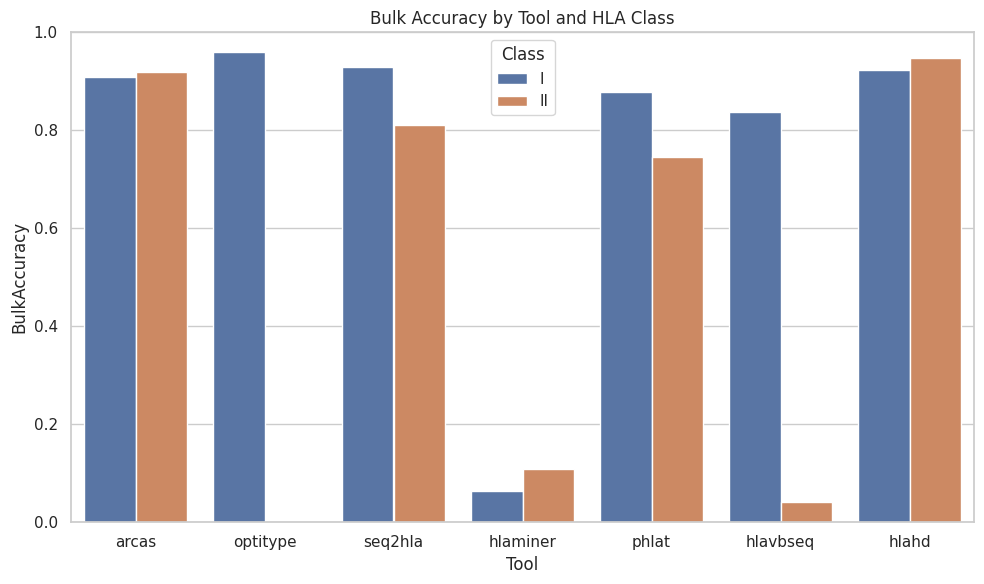

In [5]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

# --- Helper Functions ---

def reformat_allele(allele: str, resolution: int = 2) -> str:
    """
    Reformats an allele string to a standard format.
    For two-field resolution:
      "A*01:03:XX" -> "A*01:03"
    For one-field resolution:
      "A*01:03" -> "A*01"
    """
    allele = allele.strip()
    if "*" not in allele:
        return allele
    gene, rest = allele.split("*", 1)
    fields = rest.split(":")
    if resolution == 1:
        return f"{gene}*{fields[0]}"
    elif resolution == 2:
        if len(fields) >= 2:
            return f"{gene}*{fields[0]}:{fields[1]}"
        else:
            return f"{gene}*{fields[0]}"
    else:
        return allele

def compare_allele_pair(gs_alleles: list, pre_alleles: list, resolution: int = 2) -> int:
    """
    Standard pairwise comparison of a pair of GS alleles with a pair of predicted alleles.
    Returns the maximum number of matches (0, 1, or 2) by comparing both parallel and cross.
    """
    gs_fmt = [reformat_allele(a, resolution) for a in gs_alleles]
    pre_fmt = [reformat_allele(a, resolution) for a in pre_alleles]
    parallel = (gs_fmt[0] == pre_fmt[0]) + (gs_fmt[1] == pre_fmt[1])
    cross = (gs_fmt[0] == pre_fmt[1]) + (gs_fmt[1] == pre_fmt[0])
    return max(parallel, cross)

def get_dynamic_loci_from_gs(gs_df: pd.DataFrame) -> list:
    """
    Assumes the first column of gs_df is the sample identifier.
    Every column after that corresponds to a locus. If a column name contains a ".1" suffix,
    it is removed. Returns a unique list of locus names.
    """
    loci = set()
    for col in gs_df.columns[1:]:
        locus = col.split('.')[0]
        loci.add(locus)
    return list(loci)

# --- Parameters and Setup ---

# Define the tool names and dataset numbers.
tools = ["arcas", "optitype", "seq2hla", "hlaminer", "phlat", "hlavbseq", "hlahd"]
dataset_nums = range(1, 9)

# Define which loci are Class I and which are Class II.
classI_loci = {"A", "B", "C"}
classII_loci = {"DRB1", "DQB1"}

# Create a structure to hold counts per tool.
# For each tool, we will sum separately correct and total calls for class I and class II.
tool_counts = {tool: {"I": {"correct": 0, "calls": 0},
                      "II": {"correct": 0, "calls": 0}}
               for tool in tools}

resolution = 2  # two-field accuracy
filter_option = False  # adjust as needed

# --- Loop over Tools and Datasets ---
for tool in tools:
    for ds in dataset_nums:
        gs_file = f"../datasets/{ds}_gs.csv"         # Gold-standard file for dataset ds.
        pre_file = f"../results/standard/{tool}_d{ds}.csv"     # Prediction file for the tool on dataset ds.
        try:
            # Read the gold-standard and prediction files.
            gs_df = pd.read_csv(gs_file)
            pre_df = pd.read_csv(pre_file)
            # Get the dynamic list of loci from gs_df (skip first column).
            loci = get_dynamic_loci_from_gs(gs_df)
            # Merge on sample identifier: first column of gs_df and "ERR" in pre_df.
            id_col_gs = gs_df.columns[0]
            merged_df = pd.merge(gs_df, pre_df, left_on=id_col_gs, right_on="ERR",
                                 suffixes=("_gs", "_pre"))
            
            # Process each sample row.
            for _, row in merged_df.iterrows():
                for locus in loci:
                    # Skip loci that are not in our class definitions.
                    if locus not in classI_loci and locus not in classII_loci:
                        continue

                    # Retrieve gold-standard alleles from GS columns for this locus.
                    gs_alleles_raw = []
                    col1 = f"{locus}_gs"
                    col2 = f"{locus}.1_gs"
                    if col1 in row and not pd.isna(row[col1]):
                        gs_alleles_raw.extend([a.strip() for a in str(row[col1]).split("/")])
                    if col2 in row and not pd.isna(row[col2]):
                        gs_alleles_raw.extend([a.strip() for a in str(row[col2]).split("/")])
                    if not gs_alleles_raw:
                        continue
                    # Form a set of reformatted alleles.
                    gs_allele_set = set(reformat_allele(a, resolution) for a in gs_alleles_raw)
                    # Determine if the GS cell is ambiguous (has >2 distinct alleles).
                    use_ambiguous = len(gs_allele_set) > 2
                    if not use_ambiguous:
                        gs_alleles = list(gs_allele_set)
                        if len(gs_alleles) == 1:
                            gs_alleles = [gs_alleles[0], gs_alleles[0]]
                    # Retrieve predicted alleles.
                    pre_alleles = []
                    pre_col1 = f"{locus}_pre"
                    pre_col2 = f"{locus}.1_pre"
                    if pre_col1 in row and not pd.isna(row[pre_col1]):
                        pre_alleles.extend([a.strip() for a in str(row[pre_col1]).split("/")])
                    if pre_col2 in row and not pd.isna(row[pre_col2]):
                        pre_alleles.extend([a.strip() for a in str(row[pre_col2]).split("/")])
                    if not pre_alleles:
                        continue
                    if len(pre_alleles) == 1:
                        pre_alleles = [pre_alleles[0], pre_alleles[0]]
                    elif len(pre_alleles) > 2:
                        pre_alleles = pre_alleles[:2]
                    if len(pre_alleles) != 2:
                        continue
                        
                    # Compare predicted alleles to gold-standard.
                    if use_ambiguous:
                        # In ambiguous mode, count a match if the predicted allele (formatted) is in the union.
                        pred1 = reformat_allele(pre_alleles[0], resolution)
                        pred2 = reformat_allele(pre_alleles[1], resolution)
                        match_count = (1 if pred1 in gs_allele_set else 0) + (1 if pred2 in gs_allele_set else 0)
                    else:
                        match_count = compare_allele_pair(gs_alleles, pre_alleles, resolution)
                    
                    # Determine the class for this locus.
                    if locus in classI_loci:
                        cls = "I"
                    elif locus in classII_loci:
                        cls = "II"
                    else:
                        continue
                    # For each locus, we assume two calls (since diploid).
                    tool_counts[tool][cls]["calls"] += 2
                    tool_counts[tool][cls]["correct"] += match_count
        except Exception as e:
            print(f"Error processing {tool} on dataset {ds}: {e}")

# --- Build DataFrame for Bulk Accuracy by Class ---
rows = []
for tool in tools:
    for cls in ["I", "II"]:
        correct = tool_counts[tool][cls]["correct"]
        calls = tool_counts[tool][cls]["calls"]
        bulk_accuracy = correct / calls if calls > 0 else None
        rows.append({"Tool": tool, "Class": cls, "BulkAccuracy": bulk_accuracy})

df_bulk = pd.DataFrame(rows)
print("Bulk Accuracy by Tool and Class:")
print(df_bulk)

# --- Plotting using Seaborn ---
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Tool", y="BulkAccuracy", hue="Class", data=df_bulk)
ax.set_title("Bulk Accuracy by Tool and HLA Class")
ax.set_ylim(0,1)
plt.tight_layout()
plt.show()


# Figures

In [84]:
from matplotlib import colors as mcolors


# color palette
palette = [mcolors.to_rgba(c) for c in [ "#be6968", '#61ba40',"#6590ca",'coral','orange','gold','skyblue','cornflowerblue', '#e9af61',"#49adad" ] ]


/var/folders/zf/yd9tbm290zxd2z970lnbp4340000gp/T/ipykernel_93199/979457400.py:5: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=field_1_df,x="Tool",y="BulkAccuracy%",ax=ax[0],hue="type",palette=palette)
/var/folders/zf/yd9tbm290zxd2z970lnbp4340000gp/T/ipykernel_93199/979457400.py:6: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=field_2_df,x="Tool",y="BulkAccuracy%",ax=ax[1],hue="type",palette=palette)


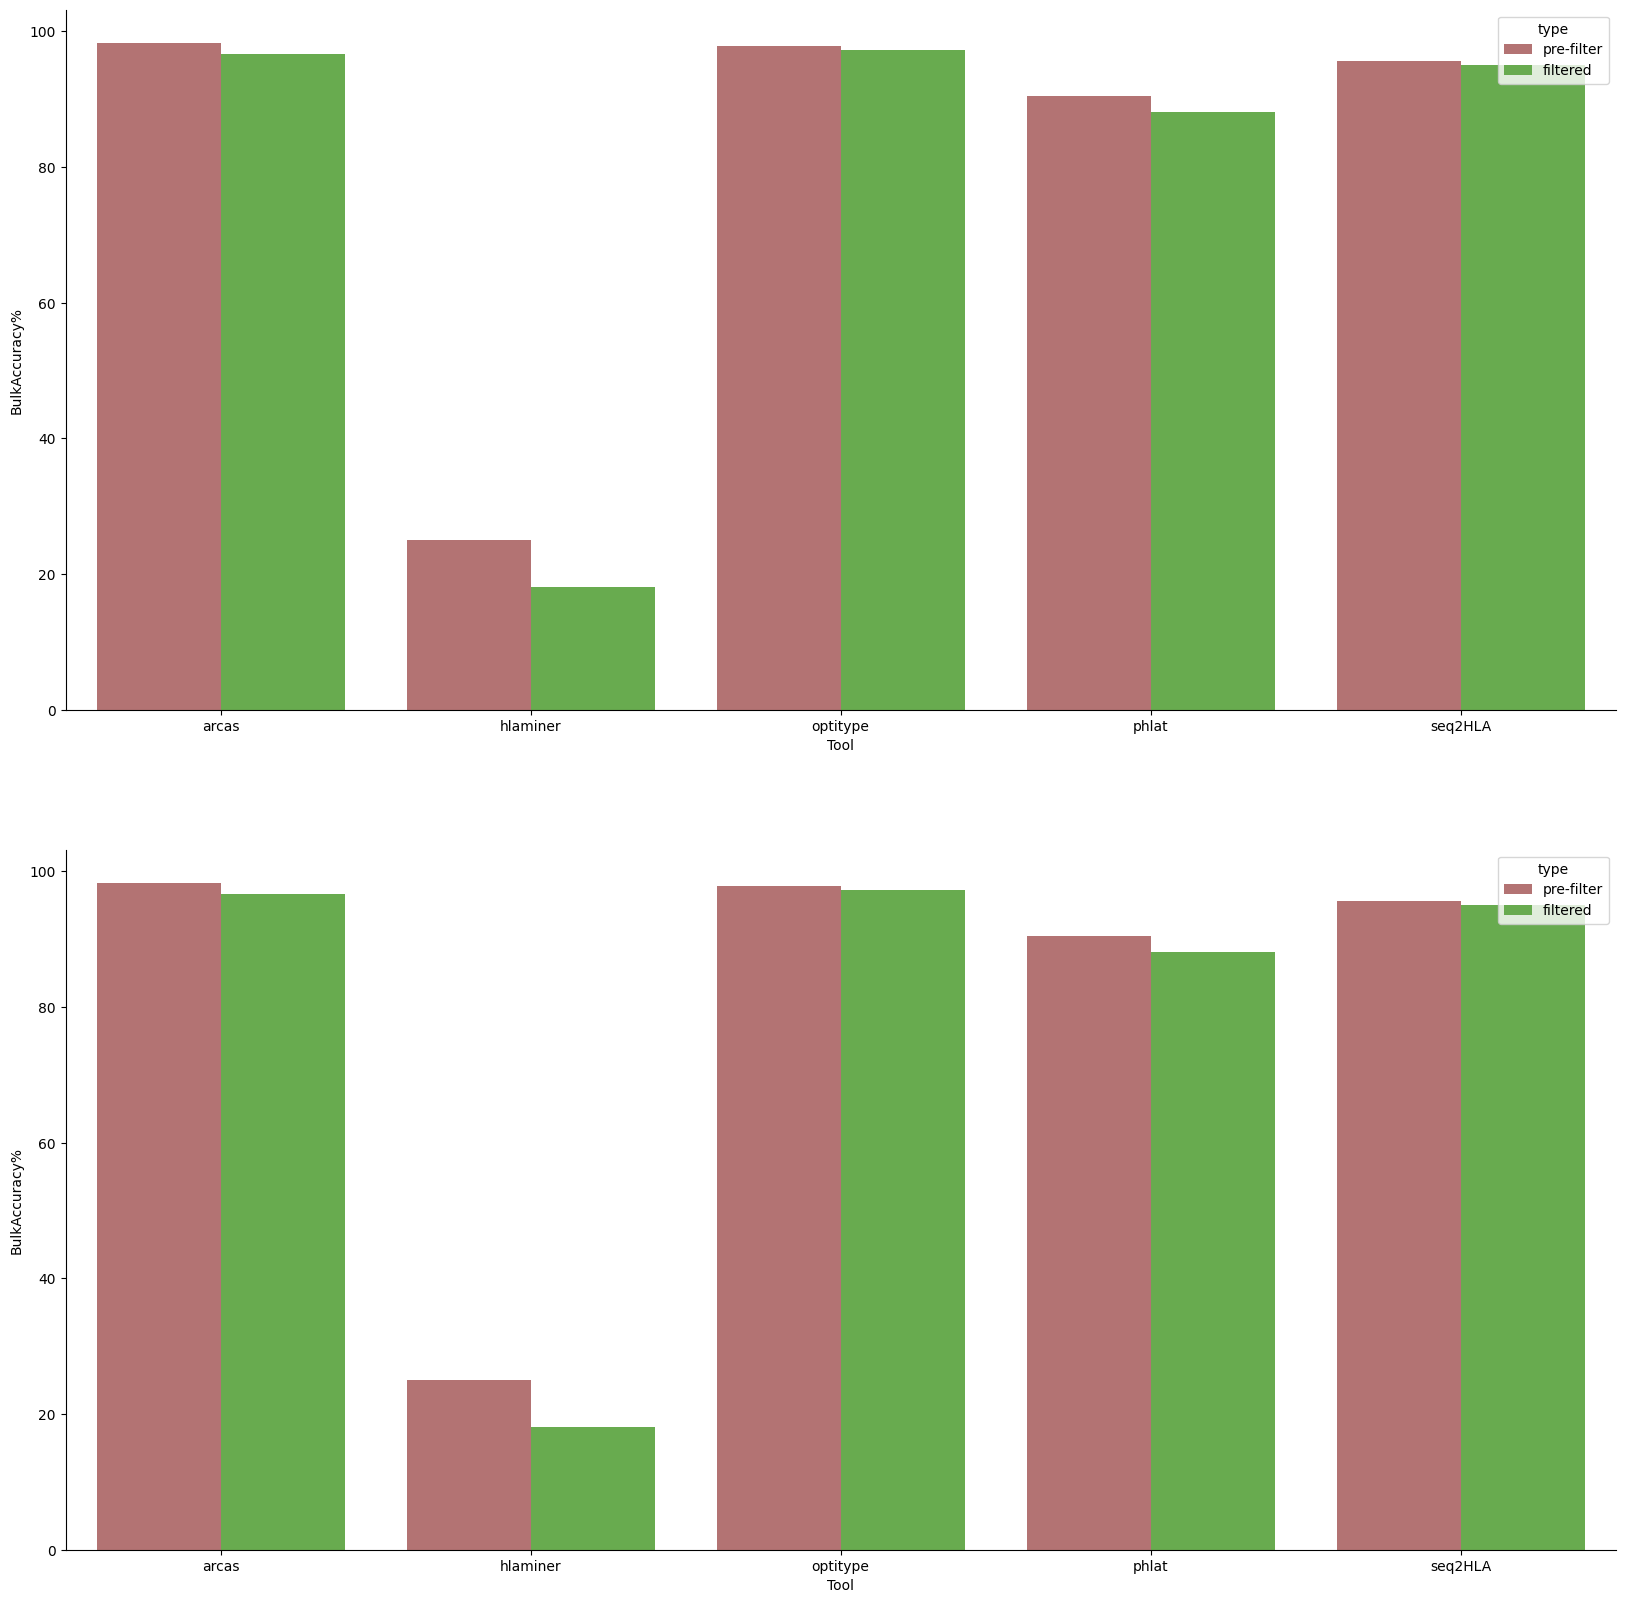

In [ ]:
fig = plt.figure(figsize=(20,20))
#add some p value significance to this 
#left plot
ax=fig.subplots(2,1)
sns.barplot(data=field_1_df,x="Tool",y="BulkAccuracy%",ax=ax[0],hue="type",palette=palette)
sns.barplot(data=field_2_df,x="Tool",y="BulkAccuracy%",ax=ax[1],hue="type",palette=palette)
#sns.barplot(data=results_2field,x="Tool",y="BulkAccuracy%",ax=ax[0,0],hue="Tool",palette=palette)
#sns.barplot(data=results_1field,x="Tool",y="BulkAccuracy%",ax=ax[0,1],hue="Tool",palette=palette)
#sns.barplot(data=results_2field_filtered,x="Tool",y="BulkAccuracy%",ax=ax[1,0],hue="Tool",palette=palette)
#sns.barplot(data=results_1field_filtered,x="Tool",y="BulkAccuracy%",ax=ax[1,1],hue="Tool",palette=palette)
sns.despine()

/var/folders/zf/yd9tbm290zxd2z970lnbp4340000gp/T/ipykernel_93199/3689411694.py:5: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=field_1_df,x="Tool",y="BulkAccuracy",ax=ax[0],hue="type",palette=palette,log_scale=2)
/var/folders/zf/yd9tbm290zxd2z970lnbp4340000gp/T/ipykernel_93199/3689411694.py:6: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=field_2_df,x="Tool",y="BulkAccuracy",ax=ax[1],hue="type",palette=palette,log_scale=2)


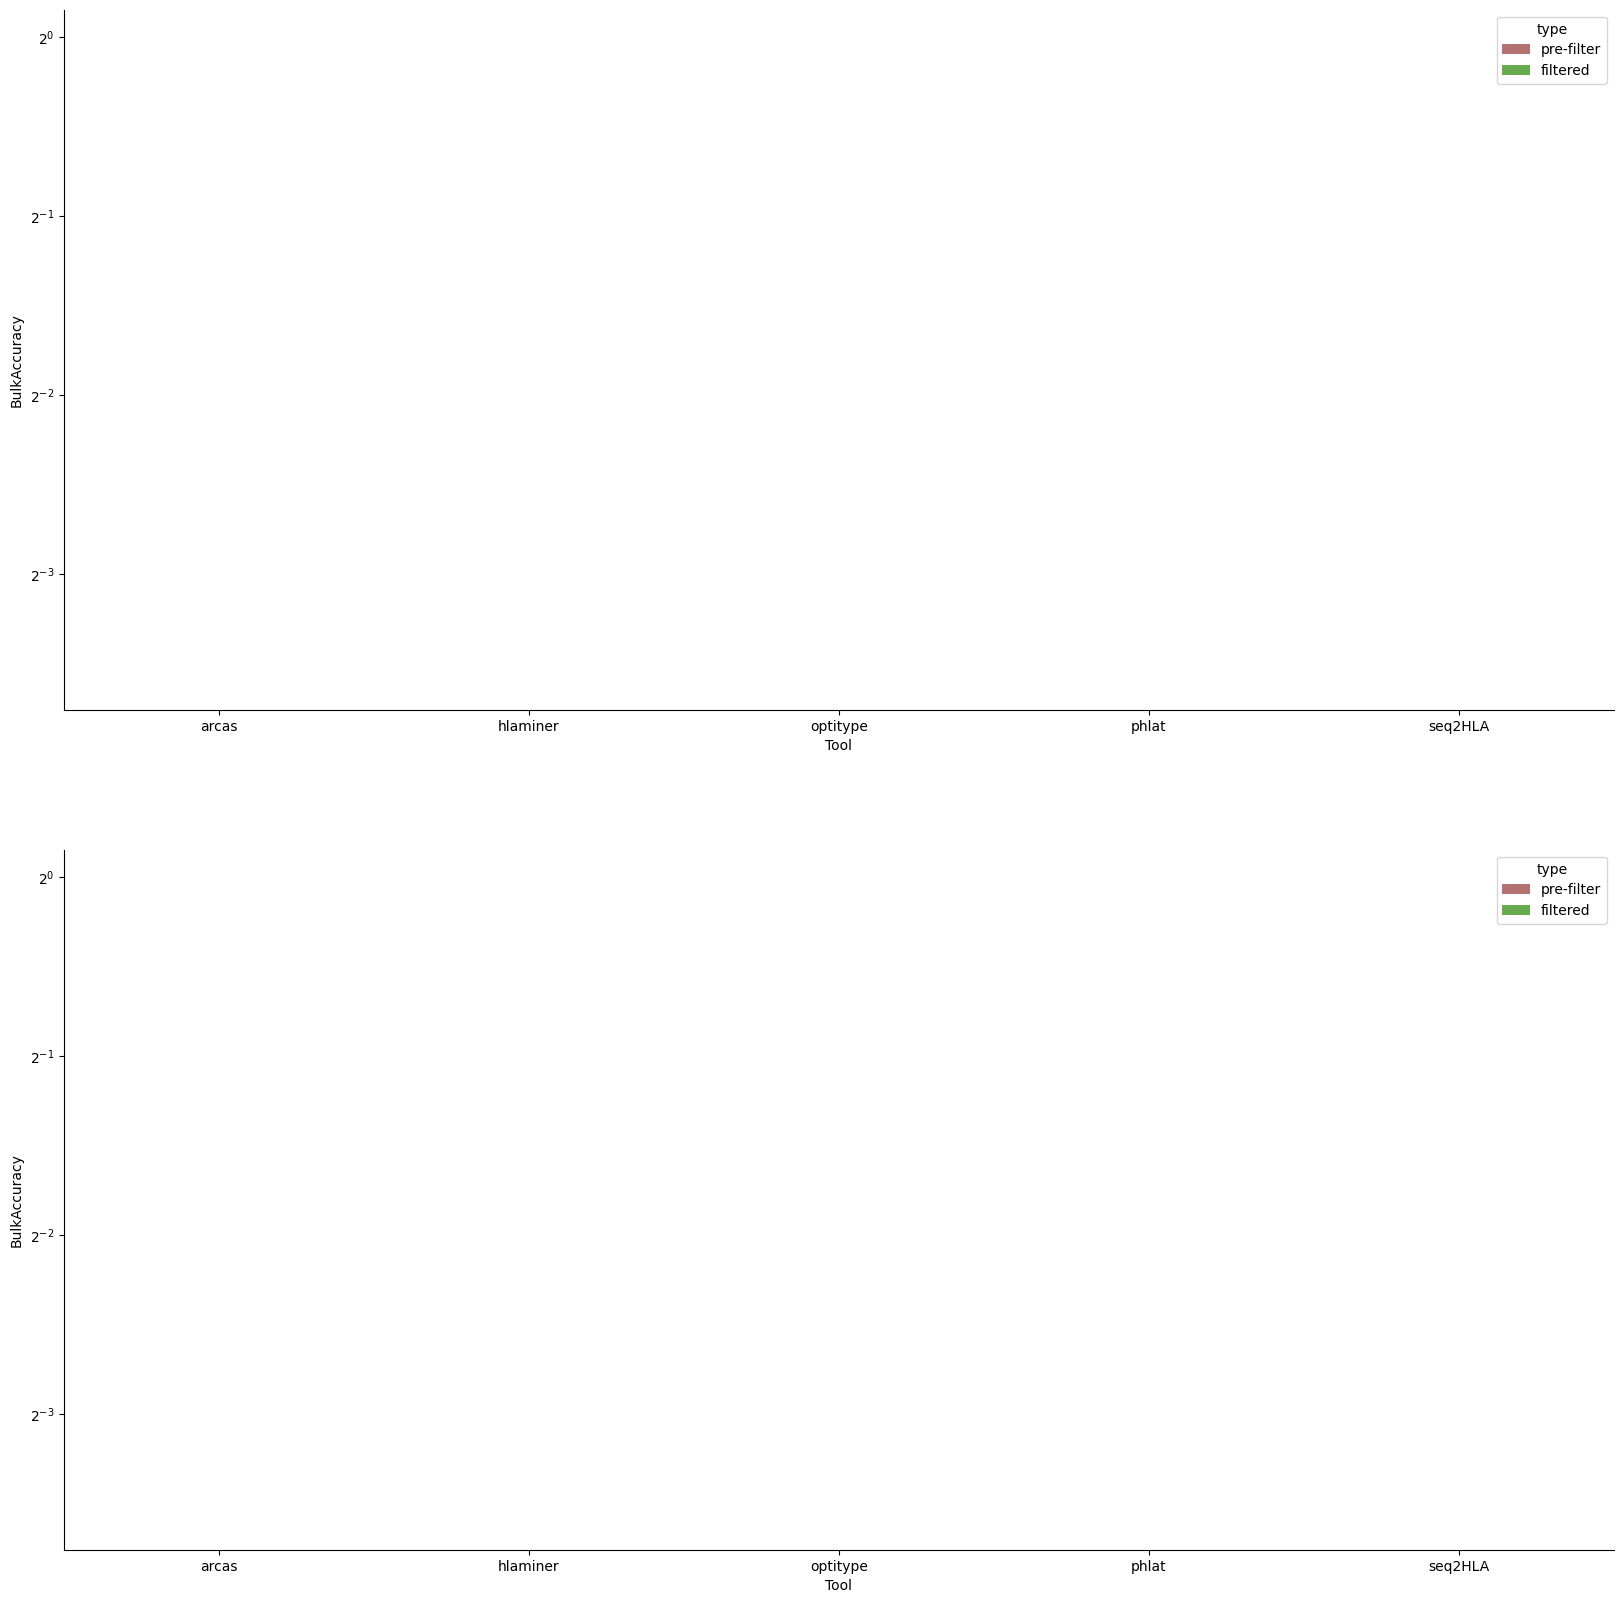

In [139]:
fig = plt.figure(figsize=(20,20))
#add some p value significance to this 
#left plot
ax=fig.subplots(2,1)
sns.barplot(data=field_1_df,x="Tool",y="BulkAccuracy",ax=ax[0],hue="type",palette=palette,log_scale=2)
sns.barplot(data=field_2_df,x="Tool",y="BulkAccuracy",ax=ax[1],hue="type",palette=palette,log_scale=2)
#sns.barplot(data=results_2field,x="Tool",y="BulkAccuracy%",ax=ax[0,0],hue="Tool",palette=palette)
#sns.barplot(data=results_1field,x="Tool",y="BulkAccuracy%",ax=ax[0,1],hue="Tool",palette=palette)
#sns.barplot(data=results_2field_filtered,x="Tool",y="BulkAccuracy%",ax=ax[1,0],hue="Tool",palette=palette)
#sns.barplot(data=results_1field_filtered,x="Tool",y="BulkAccuracy%",ax=ax[1,1],hue="Tool",palette=palette)
sns.despine()

## bulk accuracy by class vertical split

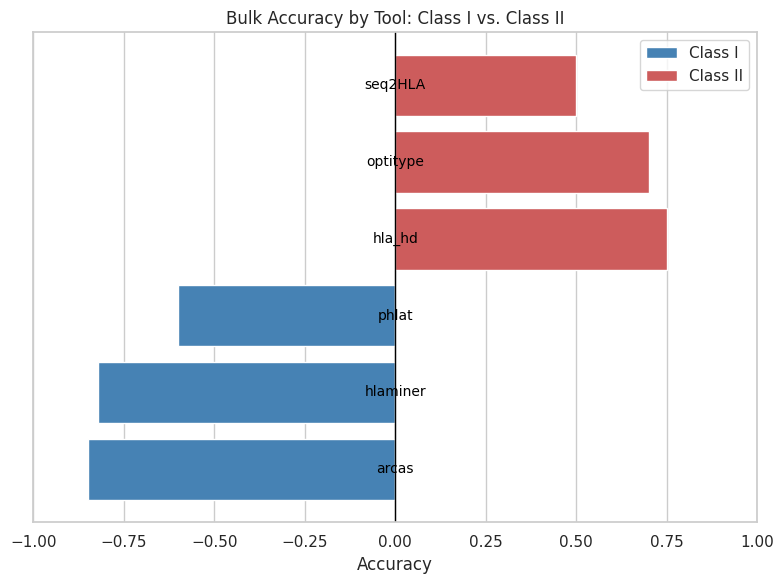

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Example Data ---
# Assume df_bulk is a DataFrame with columns: Tool, Class, BulkAccuracy.
# For demonstration, here is a small example:
data = {
    "Tool": ["arcas", "hla_hd", "hlaminer", "optitype", "phlat", "seq2HLA"],
    "Class": ["I", "II", "I", "II", "I", "II"],
    "BulkAccuracy": [0.85, 0.75, 0.82, 0.70, 0.60, 0.50]
}
# We'll duplicate the data so that each tool has both Class I and Class II entries.
df_bulk = pd.DataFrame(data)
# Pivot to get one row per tool with separate columns.
df_pivot = df_bulk.pivot(index="Tool", columns="Class", values="BulkAccuracy").reset_index()
df_pivot = df_pivot.rename(columns={"I": "ClassI", "II": "ClassII"})
# Fill missing values with 0 if any (optional)
df_pivot = df_pivot.fillna(0)

# --- Prepare Data for a Diverging Plot ---
# Create a negative column for Class I to plot to the left.
df_pivot["ClassI_neg"] = -df_pivot["ClassI"]

# Sort by Class I (or Class II) if desired so that bars align in order.
df_pivot = df_pivot.sort_values("ClassI_neg", ascending=True)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(8, 6))

# Plot Class I bars (negative values) and Class II bars (positive values).
ax.barh(df_pivot["Tool"], df_pivot["ClassI_neg"], color="steelblue", label="Class I")
ax.barh(df_pivot["Tool"], df_pivot["ClassII"], color="indianred", label="Class II")

# Draw a vertical line at x=0.
ax.axvline(0, color="black", linewidth=1)

# Set x-axis limits (assuming accuracy is in the range [0,1]).
ax.set_xlim(-1, 1)

# Remove the default y-tick labels.
ax.set_yticks([])

# Manually add tool labels at x=0 (centered).
for idx, tool in enumerate(df_pivot["Tool"]):
    ax.text(0, idx, tool, ha="center", va="center", fontsize=10, color="black")

# Add x-axis label and title.
ax.set_xlabel("Accuracy")
ax.set_title("Bulk Accuracy by Tool: Class I vs. Class II")

# Add legend.
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()
